# <span style="color:teal">RBFE Network Tutorial</span>
This is the RBFE (Relative Binding Free Energy) workflow jupyter notebook for the September 2022 CCPBioSim Workshop.
It includes core as well as <span style="color:purple">extra</span> options.

##### <span style="color:teal">Previous knowledge</span> 
 - Basic python
 - Part 1 of this workshop (Introduction to Alchemistry with BioSimSpace)
    - this should include basic knowledge of the principles behind RBFE

##### <span style="color:teal">Learning objectives</span>  
 - Setup an FEP (Free Energy Perturbation) pipeline using BioSimSpace and SOMD.
 - Analyse and plot the results.


##### <span style="color:teal">Authors</span>  
 - Anna Herz (@annamherz)
 - This is adapted from the FEP BioSimSpace Tutorial written by Jenke Scheen (https://github.com/michellab/BioSimSpaceTutorials/tree/main/04_fep).


 <span style="color:pink">Further reading </span> references some sections of the [LiveComs Best Practices for Alchemical Free Energy Calculations](https://livecomsjournal.org/index.php/livecoms/article/view/v2i1e18378).

In [1]:
# import libraries
import BioSimSpace as BSS
import os
import glob
import csv
import numpy as np
# for the analysis
from alchemlyb.visualisation import plot_mbar_overlap_matrix as _plot_mbar_overlap_matrix
from alchemlyb.visualisation import plot_ti_dhdl as _plot_ti_dhdl
import math
import pandas as pd

# define all the folder locations
main_folder =  os.getcwd()
print(main_folder)
# scripts should be located in:
scripts_folder = f"{main_folder}/scripts"
# other folders
input_dir = f"{main_folder}/inputs"
path_to_ligands = f"{main_folder}/inputs/ligands"

/home/anna/anaconda3/envs/biosimspace-dev/lib/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/anna/anaconda3/envs/biosimspace-dev/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/anna/anaconda3/envs/biosimspace-dev/lib/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/anna/anaconda3/envs/biosimspace-dev/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)



Sending anonymous Sire usage statistics to http://siremol.org.
For more information, see http://siremol.org/analytics
To disable, set the environment variable 'SIRE_DONT_PHONEHOME' to 1
To see the information sent, set the environment variable 
SIRE_VERBOSE_PHONEHOME equal to 1. To silence this message, set
the environment variable SIRE_SILENT_PHONEHOME to 1.



/home/anna/Documents/september_2022_workshops/bssccpbiosim2022/RBFE_tutorial


##### <span style="color:teal">Choosing the parameters for the FEP runs</span>

Running the below cell will generate the input nodes that can be used to choose various parameters for the FEP network.

This includes the forcefields used (ligand, protein, water), the number of lambda windows, and the threshold for the LOMAP score. This threshold will be used to define a perturbation as being either 'regular' or 'difficult', and consequently how many lambda windows will be used.


In [2]:
node = BSS.Gateway.Node("A node to create input files for molecular dynamics simulation.")

node.addInput("Ligand FF", BSS.Gateway.String(help="Force field to parameterise ligands with.",
                                             allowed=["GAFF1", "GAFF2"],
                                             default="GAFF2"))

node.addInput("Protein FF", BSS.Gateway.String(help="Force field to parameterise the protein with.",
                                             allowed=["FF03", "FF14SB", "FF99", "FF99SB", "FF99SBILDN"],
                                             default="FF14SB"))

node.addInput("Water Model", BSS.Gateway.String(help="Water model to use.",
                                             allowed=["SPC", "SPCE", "TIP3P", "TIP4P", "TIP5P"],
                                             default="TIP3P"))

node.addInput("Box Edges", BSS.Gateway.String(help="Size of water box around molecular system.",
                                             allowed=["20*angstrom", "25*angstrom", "30*angstrom", "35*angstrom", "45*angstrom", "5*nm", "7*nm", "10*nm"],
                                             default="20*angstrom"))

node.addInput("Box Shape", BSS.Gateway.String(help="Geometric shape of water box.",
                                             allowed=["cubic", "truncatedOctahedron"],
                                             default="cubic"))

node.addInput("Run Time", BSS.Gateway.String(help="The sampling time per lambda window.",
                                             allowed=["10*ps", "100*ps", "1*ns", "2*ns", "3*ns", "4*ns", "5*ns", "8*ns", "10*ns", "12*ns", "15*ns"],
                                             default="2*ns"))

node.addInput("FEP Engine", BSS.Gateway.String(help="Engine to run FEP with.",
                                             allowed=[e.upper() for e in BSS.FreeEnergy.engines()],
                                             default="SOMD"))

node.addInput("LambdaWindows", BSS.Gateway.String(help="The number of lambda windows for regular transformations.",
                                             allowed=["3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20"],
                                             default="11"))

node.addInput("DiffLambdaWindows", BSS.Gateway.String(help="The number of lambda windows for difficult transformations.",
                                             allowed=["4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20"],
                                             default="17"))
                                             
node.addInput("LOMAP Threshold", BSS.Gateway.String(help="The LOMAP score threshold to define difficult transformations.",
                                             allowed=["0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9"],
                                             default="0.4"))

node.showControls()

Box(children=(Box(children=(Box(children=(Label(value='Ligand FF: Force field to parameterise ligands with.'),…

After the parameters are chosen, the next step for generating an FEP network is to check the structure of the protein and ligands for which this will be run. 


The ligand files are provided in the inputs/ligands folder. They were generated using [FEGrow](https://github.com/cole-group/FEgrow).


##### <span style="color:teal">The FEP Network</span>  

The reliability of FEP calculations is typically higher for transformations with fewer heavy atom changes and some other rules (e.g. no ring formations). LOMAP is a package that contains heuristics for this and is able to come up with a network for us; BioSimSpace contains a function generateNetwork() that uses LOMAP to come up with the perturbation network that visualises the desired perturbations. Additionally, a LOMAP score is calculated which quantifies the likeliness that the FEP prediction will be reliable (0 means unlikely, 1 means highly likely).

 <span style="color:pink">Further reading </span>: 7.1 (perturbation maps, Figure 5)

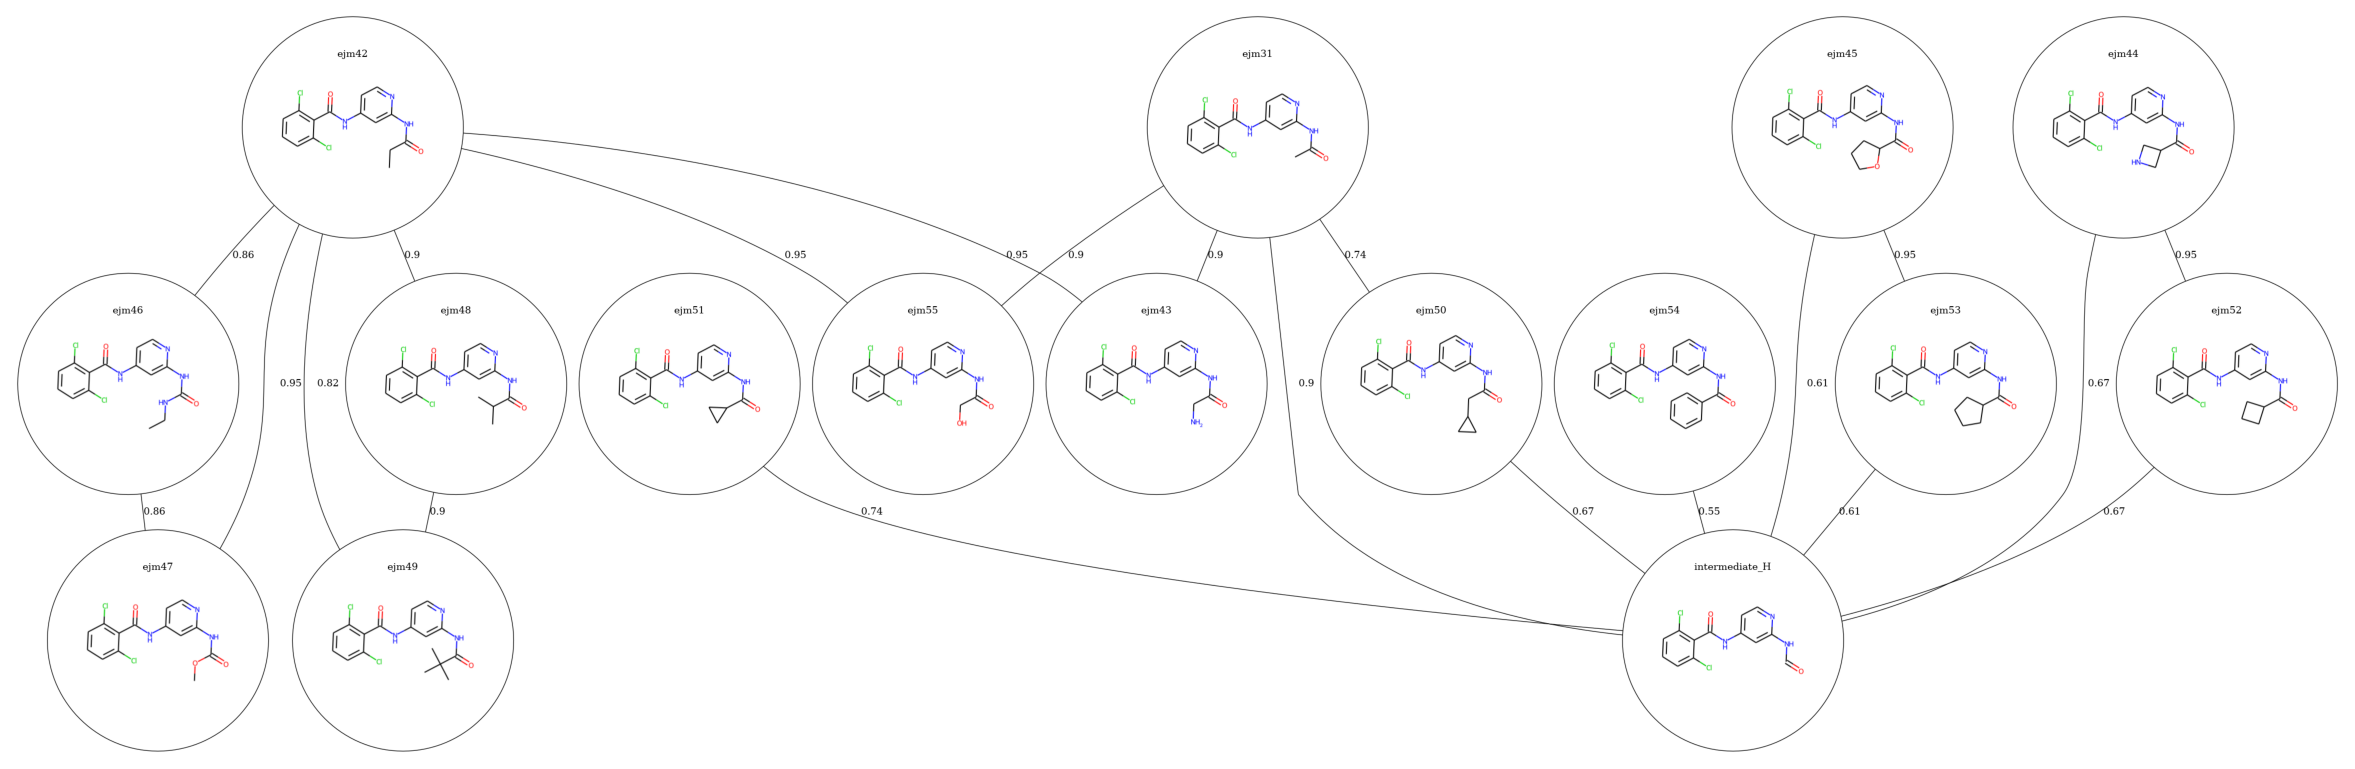

In [10]:
#generate transformation network based on ligands
path_to_ligands ="/home/anna/Documents/september_2022_workshops/bssccpbiosim2022/RBFE_tutorial/inputs/ligands"
ligand_files = sorted(glob.glob(f"{path_to_ligands}/*.sdf"))

ligands = []
ligand_names = []

for filepath in ligand_files:
    # append the molecule object to a list.
    ligands.append(BSS.IO.readMolecules(filepath)[0])
    
    # append the molecule name to another list so that we can use the name of each molecule in our workflow.
    ligand_names.append(filepath.split("/")[-1].replace(".sdf",""))

transformations, lomap_scores = BSS.Align.generateNetwork(ligands, plot_network=True, names=ligand_names)


BioSimSpace uses NetworkX which works with node indices for node names. Let's adjust our list of edges to have ligand names instead of ligand indices. We also generate a dictionary that contains all of the network information we need downstream.

In [13]:
pert_network_dict = {}
transformations_named = [(ligand_names[transf[0]], ligand_names[transf[1]]) for transf in transformations]
for score, transf in sorted(zip(lomap_scores, transformations_named)):
    pert_network_dict[transf] = score
    print(transf, score)


('ejm54', 'intermediate_H') 0.54881
('ejm45', 'intermediate_H') 0.60653
('ejm53', 'intermediate_H') 0.60653
('ejm44', 'intermediate_H') 0.67032
('ejm50', 'intermediate_H') 0.67032
('ejm52', 'intermediate_H') 0.67032
('ejm31', 'ejm50') 0.74082
('ejm51', 'intermediate_H') 0.74082
('ejm42', 'ejm49') 0.81873
('ejm42', 'ejm46') 0.86071
('ejm46', 'ejm47') 0.86071
('ejm31', 'ejm43') 0.90484
('ejm31', 'ejm55') 0.90484
('ejm31', 'intermediate_H') 0.90484
('ejm42', 'ejm48') 0.90484
('ejm48', 'ejm49') 0.90484
('ejm42', 'ejm43') 0.95123
('ejm42', 'ejm47') 0.95123
('ejm42', 'ejm55') 0.95123
('ejm44', 'ejm52') 0.95123
('ejm45', 'ejm53') 0.95123


Unfortunately, even cutting-edge perturbation network generators such as LOMAP require some manual tweaking. In some cases, a ligand will have poor LOMAP scores on its edges and is therefore likely to be unreliable. To increase its reliability we often want to create an additional edge to this ligand, which can be easily done by appending the edge to our list of edges. Additionally, we usually want to avoid any ring breaking/forming transformations.

To this end, we can introduce a ligand 'intermediate_H' that contains no atoms on the R-group. This makes it easier for the FEP code to perturb to cyclical R-groups. Using this type of network manipulation allows the user to include some cycles into the network, which is good for statistical performance of FEP predictions.

Copy this ligand from the inputs/ligands/intermediate folder into the inputs/ligands folder and rerun the above network generation.

Below, add any other perturbations, either with the intermediate, or any other ligands to complete a cycle.


In [14]:
pert_network_dict[('ejm47', 'ejm49')] = 0.1

pert_network_dict

{('ejm54', 'intermediate_H'): 0.54881,
 ('ejm45', 'intermediate_H'): 0.60653,
 ('ejm53', 'intermediate_H'): 0.60653,
 ('ejm44', 'intermediate_H'): 0.67032,
 ('ejm50', 'intermediate_H'): 0.67032,
 ('ejm52', 'intermediate_H'): 0.67032,
 ('ejm31', 'ejm50'): 0.74082,
 ('ejm51', 'intermediate_H'): 0.74082,
 ('ejm42', 'ejm49'): 0.81873,
 ('ejm42', 'ejm46'): 0.86071,
 ('ejm46', 'ejm47'): 0.86071,
 ('ejm31', 'ejm43'): 0.90484,
 ('ejm31', 'ejm55'): 0.90484,
 ('ejm31', 'intermediate_H'): 0.90484,
 ('ejm42', 'ejm48'): 0.90484,
 ('ejm48', 'ejm49'): 0.90484,
 ('ejm42', 'ejm43'): 0.95123,
 ('ejm42', 'ejm47'): 0.95123,
 ('ejm42', 'ejm55'): 0.95123,
 ('ejm44', 'ejm52'): 0.95123,
 ('ejm45', 'ejm53'): 0.95123,
 ('ejm47', 'ejm49'): 0.1}

Another way to manipulate the dictionary is to remove entries (i.e. remove edges from the network). When we look at the edges suggested by LOMAP that have low scores, we see that some are likely to be unreliable in FEP. Luckily, this is because cycle formation/removal in a single-topology-style FEP must be from/to a hydrogen, not a carbon atom. This is why we have introduced 'intermediate_H', so this has largely been solved by generating the network again above. Still, the below syntax can be used if any edges are to be removed.

In [ ]:
for key in [('A', 'B'), ('C', 'D')]:
    del pert_network_dict[key]
pert_network_dict

##### <span style="color:teal">Preparing for the FEP pipeline</span>  

Once we have our protein, ligands, and have planned the network, we need to write all the files we need for running the FEP Pipeline.

This includes the following files:
 - ligands.dat , which includes all the ligands that must be prepared
 - network.dat , which includes all the perturbations and the number of lambda windows
 - protocol.dat , which includes the details of the protocol used

In [16]:
# write ligands file.
with open("ligands.dat", "w") as ligands_file:
    writer = csv.writer(ligands_file)
    for lig in ligand_names:
        writer.writerow([lig])

# write perts file. Base the lambda schedule on the file generated in the previous cell.
np.set_printoptions(formatter={'float': '{: .4f}'.format})

# from protocol, derive the engine we want to use on the cluster.
engine = node.getInput('FEP Engine').upper()

with open("network.dat", "w") as network_file:

    writer = csv.writer(network_file, delimiter=" ")
    
    for pert, lomap_score in pert_network_dict.items():
        # based on the provided (at top of notebook) lambda allocations and LOMAP threshold, decide allocation.
        if lomap_score == None or lomap_score < float(node.getInput("LOMAP Threshold")):
            num_lambda = node.getInput("DiffLambdaWindows")
        else:
            num_lambda = node.getInput("LambdaWindows")
            
       
        # given the number of allocated lambda windows, generate an array for parsing downstream.
        lam_array_np = np.around(np.linspace(0, 1, int(num_lambda)), decimals=5)

        # make the array into a format readable by bash.
        lam_array = str(lam_array_np).replace("[ ", "").replace("]", "").replace("  ", ",").replace('\n', '')

        # write out both directions for this perturbation.
        writer.writerow([pert[0], pert[1], len(lam_array_np), lam_array, engine])
        writer.writerow([pert[1], pert[0], len(lam_array_np), lam_array, engine])         

# create protocol. 
protocol = [
    f"ligand forcefield = {node.getInput('Ligand FF')}",
    f"protein forcefield = {node.getInput('Protein FF')}",
    f"solvent = {node.getInput('Water Model')}",
    f"box edges = {node.getInput('Box Edges')}",
    f"box type = {node.getInput('Box Shape')}",
    f"protocol = default",
    f"sampling = {node.getInput('Run Time')}",
    f"engine = {node.getInput('FEP Engine').upper()}"
]

# write protocol to file.
with open("protocol.dat", "w") as protocol_file:
    writer = csv.writer(protocol_file)

    for prot_line in protocol:
        
        writer.writerow([prot_line])

##### <span style="color:teal">Parallelisation - Running the MD simulations</span>

Once all the files are written, the folder can be copied to a computing cluster so that the simulations can be parallelised. A simple example script for this for a slurm cluster (without any analysis) is included in the scripts directory.

This calls the following scripts in order:

 - Ligand preparation (BSSligprep.py) - The ligand and protein are paramaterised, combined, and solvated. Equilibration is carried out.

 - FEP preparation (BSSprepFEP.py) - For the perturbation, the ligands are mapped according to their maximum common substructure, and a perturbable system is created. The folders for the FEP run for SOMD are written.

 - Running the production windows (runFEP.sh) - As each lambda window can be run independantly of other lambda windows, this is where most of the parallelisation takes place. Each window is submitted as part of a slurm array job.


More detailed scripts, including one for an LSF cluster, are in the [BioSimSpace Tutorials](https://github.com/michellab/BioSimSpaceTutorials/tree/main/04_fep/execution_model/scripts).

As these would take too long to run in the span of a workshop, outputs from the runs above are in the outputs directory. We will analyse these below.

## <span style="color:teal">Analysis</span>
Once we have obtained our results, we want to analyse them. It is best practice to run repeats of the simulations, but in this case here we only have one repeat for each perturbation.

We will first calculate the RBFE. This is achieved relatively simply in BSS by using 'analyse'. This implements the auto equilibrium detection and statistical inefficiency from the alchemlyb python implementation in order to obtain uncorrelated samples. Following this, MBAR is used as the default analysis method.

 <span style="color:pink">Further reading </span>: 8.1,8.2,8.3

In [ ]:
# analyse all the runs in the network and place them into a dictionary for later
bound_pmf_dict = {}  # for the intial results
free_pmf_dict = {}
bound_matrix_dict = {}  # for the overlap matrix
free_matrix_dict = {}
diff_dict = {}  # for the result for that transformation

# we will also create a list of all the perturbation names for the analysis as well
perturbations = []

for line in open("./execution_model/network.dat", "r"):
    lig_0 = line.split()[0]
    lig_1 = line.split()[1]
    pert = f"{lig_0}~{lig_1}"
    pmf_free, overlap_matrix_free = BSS.FreeEnergy.Relative.analyse(f'outputs/SOMD/{pert}/free')
    pmf_bound, overlap_matrix_bound = BSS.FreeEnergy.Relative.analyse(f'outputs/SOMD/{pert}/bound')
    freenrg_rel = BSS.FreeEnergy.Relative.difference(pmf_bound, pmf_free)
    bound_pmf_dict.update({pert: pmf_bound})
    bound_matrix_dict.update({pert: overlap_matrix_bound})
    free_pmf_dict.update({pert: pmf_free})
    free_matrix_dict.update({pert: overlap_matrix_free})
    diff_dict.update({pert: freenrg_rel})
    perturbations.append(pert)


<span style="color:purple">Extra:</span>
Instead of using MBAR, try using TI (Thermodynamic Integration) to anaylse the results.
This can be done by setting the estimator to TI when analysing.

```python
pmf, overlap_matrix = BSS.FreeEnergy.Relative.analyse(f'{folder}', estimator="TI")
```

Are the results different?


##### <span style="color:teal">Checking the overlap</span>
For MBAR, we can assess the reliability of the calculations by checking the phase space overlap between lambda windows. The off-diagonals should be atleast 0.03 so that the obtained free energy estimate is reliable.

The check_overlap function should return a warning if the value for any off-diagonal is less than 0.03 - otherwise, there will be no output for it.

 <span style="color:pink">Further reading </span>: 8.5 (overlap matrix)

In [ ]:
# check the overlap for each perturbation
for pert in perturbations:
    bound_overlap = bound_matrix_dict[pert]
    BSS.FreeEnergy.Relative.check_overlap(bound_overlap)
    free_overlap = free_matrix_dict[pert]
    BSS.FreeEnergy.Relative.check_overlap(free_overlap)

We can also plot the overlap for a chosen leg of a perturbation to visualise it.

In [ ]:
pert = "ejm31~ejm42" # choose the perturbation
bound_overlap = bound_matrix_dict[pert]
free_overlap = free_matrix_dict[pert]

ax = _plot_mbar_overlap_matrix(bound_overlap) # pick either the bound or the free overlap
ax.set_title(f"Overlap matrix")

ax.show()

<span style="color:purple">Extra:</span>
If you have analysed the results using TI, plot the dhdl graph.

```python
ax = _plot_ti_dhdl([overlap])
```

We can also look at the value across lambda windows. This can be useful when considering different repeats.

##### <span style="color:teal">Comparing to experimental binding affinities</span>

Next, we want to visualise our results whilst comparing them to experimental.
In this example here, TYK2 has binding affinities in Ki, and can be converted using ΔG = RTlnK . It is important at this stage to make sure that the units match (kcal/mol).

The binding affinities have already been converted in the experimental.csv files. Using these we will then also calculate the ΔΔG.

In [ ]:
# create a dictionary for the experimental values
exper_val_dict = {}
# now we can also create a dictionary with all the experimental values for the perturbations
exper_diff_dict = {}

# open the file with the experimental values
for line in open('experimental.csv', 'r'):
    lig = line.split(",")[0]
    exper = line.split(",")[1]
    exper_err = 0.4
    exper_val_dict.update(lig:(exper, exper_err))

# calculate the experimental RBFEs
for line in open("./execution_model/network.dat", "r"):
    lig_0 = line.split()[0]
    lig_1 = line.split()[1]
    pert = f"{lig_0}~{lig_1}"
    exper_ddG = exper_val_dict[lig_1][0] - exper_val_dict[lig_0][0]
    exper_err = math.sqrt(math.pow(exper_val_dict[lig_0][1], 2) + math.pow(exper_val_dict[lig_1][1], 2))
    exper_value = (exper_ddG, exper_err)
    exper_diff_dict.update({pert:exper_value})

In [ ]:
# now we have diff_dict, exper_diff_dict, and a list of all our perturbations.
# create a data frame with all of these and their errors

data = []

for pert in perturbations:
    data.append([pert, diff_dict[pert][0], diff_dict[pert][1], exper_diff_dict[pert][0], exper_diff_dict[pert][1]])

df = pd.DataFrame(data, columns=['perturbation','calc_deltadeltaG','calc_err','exper_deltadeltaG','exper_err'])

print(df)

# this can also be saved as a csv

Now, we can plot our results against the experimental data.

In [ ]:
# plot a scatter plot

plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(8,8))

# get these based on which column the data is in.
x = (np.array(df.iloc[0:len(pert),3])).reshape(-1,1)
y = np.array(df.iloc[0:len(pert), 1])

scatterplot = [plt.scatter(x[:4], y[:4], zorder=10)]

#plotting error bars
y_er = np.array(df.iloc[0:len(pert), 2])
x_er = np.array(df.iloc[0:len(pert), 4])
plt.errorbar(x , y,
            yerr=y_er,
            # xerr=x_er,   # comment this line to hide experimental error bars \
                        # as this can sometimes overcrowd the plot.
            ls="none",
            lw=0.5, 
            capsize=2,
            color="black",
            zorder=5
            )

# plot 1/2 kcal bounds:
plt.fill_between(
                x=[-100, 100], 
                y2=[-100.25,99.75],
                y1=[-99.75, 100.25],
                lw=0, 
                zorder=-10,
                alpha=0.3,
                color="grey")
# upper bound:
plt.fill_between(
                x=[-100, 100], 
                y2=[-99.5,100.5],
                y1=[-99.75, 100.25],
                lw=0, 
                zorder=-10,
                color="grey", 
                alpha=0.2)
# lower bound:
plt.fill_between(
                x=[-100, 100], 
                y2=[-100.25,99.75],
                y1=[-100.5, 99.5],
                lw=0, 
                zorder=-10,
                color="grey", 
                alpha=0.2)

# get the bounds. This can be done with min/max or simply by hand.
all_freenrg_values_pre = []
x = (np.array(x_data.iloc[0:len(pert),3])).tolist()
y = (np.array(y_data.iloc[0:len(pert), 1])).tolist()
all_freenrg_values_pre.append(x)
all_freenrg_values_pre.append(y)

all_freenrg_values = []
for sublist in all_freenrg_values_pre:
    for item in sublist:
        all_freenrg_values.append(item)

min_lim = min(all_freenrg_values)   
max_lim = max(all_freenrg_values)

# for a scatterplot we want the axis ranges to be the same. 
plt.xlim(min_lim*1.3, max_lim*1.3)
plt.ylim(min_lim*1.3, max_lim*1.3)

plt.axhline(color="black", zorder=1)
plt.axvline(color="black", zorder=1)

#plt.xlabel('ΔΔG for experimental (kcal/mol)')
#plt.ylabel('ΔΔG for calculated (kcal/mol)')
plt.ylabel("Computed $\Delta\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")
plt.xlabel("Experimental $\Delta\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")

plt.savefig(f'r2_correlation.png')


We can also plot a bar graph of the results.

 <span style="color:pink">Further reading </span>: 8.7
